In [1]:
import sys
sys.path.append('../Modules')

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
%matplotlib inline
import NeuralNet as nn

def create_data(func, n=300):
    t = np.random.uniform(size=(n, 1))
    x = func(t) + np.random.uniform(-0.05, 0.05, size=(n, 1))
    return x, t

def func(x):
        return x + 0.3 * np.sin(2 * np.pi * x)

def sample(x, t, n=None):
    assert len(x) == len(t)
    N = len(x)
    if n is None:
        n = N
    indices = np.random.choice(N, n, replace=False)
    return x[indices], t[indices]

x_train, y_train = create_data(func)

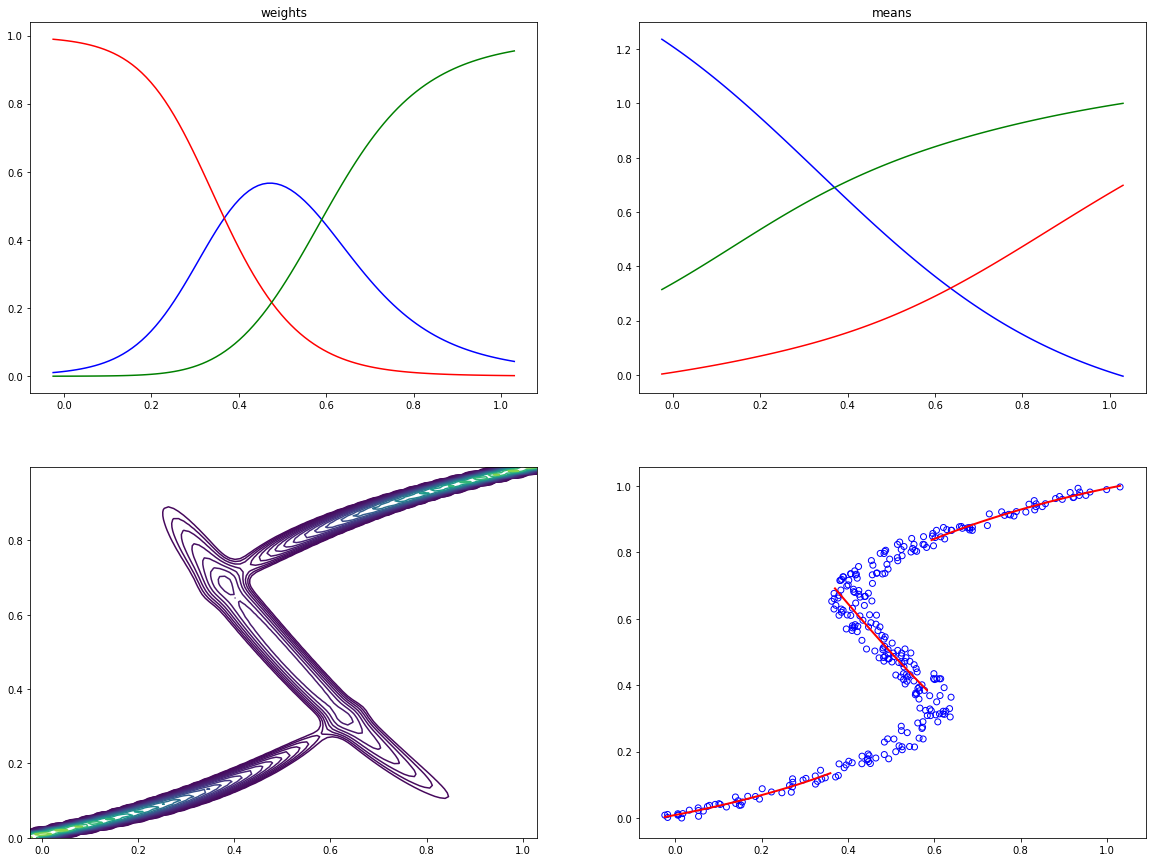

In [2]:
class MixtureDensityNetwork(nn.Network):
    
    def __init__(self, n_components):
        truncnorm = st.truncnorm(a=-0.2, b=0.2, scale=0.1)
        self.n_components = n_components
        super().__init__(
            w1=truncnorm.rvs((1, 5)),
            b1=np.zeros(5),
            w2_c=truncnorm.rvs((5, n_components)),
            b2_c=np.zeros(n_components),
            w2_m=truncnorm.rvs((5, n_components)),
            b2_m=np.zeros(n_components),
            w2_s=truncnorm.rvs((5, n_components)),
            b2_s=np.zeros(n_components)
        )

    def __call__(self, x, y=None):
        h = nn.tanh(x @ self.w1 + self.b1)
        coef = nn.softmax(h @ self.w2_c + self.b2_c)
        mean = h @ self.w2_m + self.b2_m
        std = nn.exp(h @ self.w2_s + self.b2_s)
        self.py = nn.random.GaussianMixture(coef, mean, std, data=y)
        return self.py
    
model = MixtureDensityNetwork(3)
optimizer = nn.optimizer.Adam(model, 1e-4)

for i in range(30000):
    model.clear()
    batch = sample(x_train, y_train, n=100)
    model(x_train, y_train)
    log_likelihood = model.log_pdf()
    log_likelihood.backward()
    optimizer.update()
    
x, y = np.meshgrid(
    np.linspace(x_train.min(), x_train.max(), 100),
    np.linspace(y_train.min(), y_train.max(), 100))
xy = np.array([x, y]).reshape(2, -1).T

p = model(xy[:, 0].reshape(-1, 1), xy[:, 1].reshape(-1, 1))

plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.plot(x[0], p.coef.value[:100, 0], color="blue")
plt.plot(x[0], p.coef.value[:100, 1], color="red")
plt.plot(x[0], p.coef.value[:100, 2], color="green")
plt.title("weights")

plt.subplot(2, 2, 2)
plt.plot(x[0], p.mu.value[:100, 0], color="blue")
plt.plot(x[0], p.mu.value[:100, 1], color="red")
plt.plot(x[0], p.mu.value[:100, 2], color="green")
plt.title("means")

plt.subplot(2, 2, 3)
prob = p.pdf().value
levels_log = np.linspace(0, np.log(prob.max()), 21)
levels = np.exp(levels_log)
levels[0] = 0
plt.contour(x, y, prob.reshape(100, 100), levels)
plt.xlim(x_train.min(), x_train.max())
plt.ylim(y_train.min(), y_train.max())

plt.subplot(2, 2, 4)
argmax = np.argmax(p.coef.value[:100], axis=1)
for i in range(3):
    indices = np.where(argmax == i)[0]
    plt.plot(x[0, indices], p.mu.value[(indices, np.zeros_like(indices) + i)], color="r", linewidth=2)
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b")
plt.show()